In [1]:
import pandas as pd
import numpy as np

import os
import sys

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from IPython.display import Audio

import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

2022-03-07 13:48:46.553927: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-07 13:48:46.553992: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
crema = '/home/geowilso/code/geowilso/speech-emotion-recognition/raw_data/wav_files/crema/'
tess = '/home/geowilso/code/geowilso/speech-emotion-recognition/raw_data/wav_files/tess/'
ravdess = '/home/geowilso/code/geowilso/speech-emotion-recognition/raw_data/wav_files/ravdess/'
savee = '/home/geowilso/code/geowilso/speech-emotion-recognition/raw_data/wav_files/savee/'
emodb = '/home/geowilso/code/geowilso/speech-emotion-recognition/raw_data/wav_files/emodb/'

In [3]:
crema_directory_list = os.listdir(crema)

gender = []
emotion = []
path = []
female = [1002,1003,1004,1006,1007,1008,1009,1010,1012,1013,1018,1020,1021,1024,1025,1028,1029,1030,1037,1043,1046,1047,1049,
          1052,1053,1054,1055,1056,1058,1060,1061,1063,1072,1073,1074,1075,1076,1078,1079,1082,1084,1089,1091]

for i in crema_directory_list: 
    part = i.split('_')
    if int(part[0]) in female:
        temp = 'female'
    else:
        temp = 'male'
    gender.append(temp)
    
    if part[2] == 'SAD':
        emotion.append('sad')
    elif part[2] == 'ANG':
        emotion.append('angry')
    elif part[2] == 'DIS':
        emotion.append('disgust')
    elif part[2] == 'FEA':
        emotion.append('fear')
    elif part[2] == 'HAP':
        emotion.append('happy')
    elif part[2] == 'NEU':
        emotion.append('neutral')
    else:
        emotion.append('unknown')
    path.append(crema + i)
    
crema_df = pd.DataFrame(emotion, columns = ['emotion'])
crema_df = pd.concat([crema_df,pd.DataFrame(gender, columns = ['gender'])],axis=1)
crema_df = pd.concat([crema_df,pd.DataFrame(path, columns = ['path'])],axis=1)

In [4]:
def combo(df):
    return f'{df[1]}_{df[0]}'

def sad(x):
    return 1 if x.lower() == 'sad' else 0

def angry(x):
    return 1 if x.lower() == 'angry' else 0

def disgust(x):
    return 1 if x.lower() == 'disgust' else 0

def fear(x):
    return 1 if x.lower() == 'fear' else 0

def happy(x):
    return 1 if x.lower() == 'happy' else 0

def neutral(x):
    return 1 if x.lower() == 'neutral' else 0

def pos_or_neg(x):
    if x == 'happy' or x == 'surprise':
        return 'positive'
    elif x == 'neutral':
        return x
    else:
        return 'negative'

In [5]:
crema_df['source'] = 'crema'

In [6]:
crema_df.head()

,emotion,gender,path,source
0,fear,female,/home/geowilso/code/geowilso/speech-emotion-re...,crema
1,disgust,male,/home/geowilso/code/geowilso/speech-emotion-re...,crema
2,sad,male,/home/geowilso/code/geowilso/speech-emotion-re...,crema
3,happy,female,/home/geowilso/code/geowilso/speech-emotion-re...,crema
4,angry,male,/home/geowilso/code/geowilso/speech-emotion-re...,crema


In [7]:
dir_list = os.listdir(savee)

# parse the filename to get the emotions
emotion=[]
path = []
for i in dir_list:
    if i[-8:-6]=='_a':
        emotion.append('angry')
    elif i[-8:-6]=='_d':
        emotion.append('disgust')
    elif i[-8:-6]=='_f':
        emotion.append('fear')
    elif i[-8:-6]=='_h':
        emotion.append('happy')
    elif i[-8:-6]=='_n':
        emotion.append('neutral')
    elif i[-8:-6]=='sa':
        emotion.append('sad')
    elif i[-8:-6]=='su':
        emotion.append('surprise')
    else:
        emotion.append('error') 
    path.append(savee + i)
    
# Now check out the label count distribution 
savee_df = pd.DataFrame(emotion, columns = ['emotion'])
savee_df['source'] = 'savee'
savee_df = pd.concat([savee_df, pd.DataFrame(path, columns = ['path'])], axis = 1)

In [8]:
savee_df['gender'] = 'male'

In [9]:
savee_df.head()

,emotion,source,path,gender
0,fear,savee,/home/geowilso/code/geowilso/speech-emotion-re...,male
1,disgust,savee,/home/geowilso/code/geowilso/speech-emotion-re...,male
2,disgust,savee,/home/geowilso/code/geowilso/speech-emotion-re...,male
3,neutral,savee,/home/geowilso/code/geowilso/speech-emotion-re...,male
4,happy,savee,/home/geowilso/code/geowilso/speech-emotion-re...,male


In [10]:
dir_list = os.listdir(ravdess)
dir_list.sort()

emotion = []
gender = []
path = []
for i in dir_list:
    fname = os.listdir(ravdess + i)
    for f in fname:
        part = f.split('.')[0].split('-')
        emotion.append(int(part[2]))
        temp = int(part[6])
        if temp%2 == 0:
            temp = "female"
        else:
            temp = "male"
        gender.append(temp)
        path.append(ravdess + i + '/' + f)
        
ravdess_df = pd.DataFrame(emotion)
ravdess_df = ravdess_df.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
ravdess_df = pd.concat([pd.DataFrame(gender),ravdess_df],axis=1)
ravdess_df.columns = ['gender','emotion']
ravdess_df['source'] = 'ravdess'  
ravdess_df = pd.concat([ravdess_df,pd.DataFrame(path, columns = ['path'])],axis=1)

In [11]:
ravdess_df

,gender,emotion,source,path
0,male,neutral,ravdess,/home/geowilso/code/geowilso/speech-emotion-re...
1,male,fear,ravdess,/home/geowilso/code/geowilso/speech-emotion-re...
2,male,surprise,ravdess,/home/geowilso/code/geowilso/speech-emotion-re...
3,male,angry,ravdess,/home/geowilso/code/geowilso/speech-emotion-re...
4,male,fear,ravdess,/home/geowilso/code/geowilso/speech-emotion-re...
...,...,...,...,...
1435,female,surprise,ravdess,/home/geowilso/code/geowilso/speech-emotion-re...
1436,female,angry,ravdess,/home/geowilso/code/geowilso/speech-emotion-re...
1437,female,surprise,ravdess,/home/geowilso/code/geowilso/speech-emotion-re...
1438,female,neutral,ravdess,/home/geowilso/code/geowilso/speech-emotion-re...


In [12]:
dir_list = os.listdir(tess)
dir_list.sort()

path = []
emotion = []

for i in dir_list:
    fname = os.listdir(tess + i)
    for f in fname:
        if i == 'OAF_angry' or i == 'YAF_angry':
            emotion.append('angry')
        elif i == 'OAF_disgust' or i == 'YAF_disgust':
            emotion.append('disgust')
        elif i == 'OAF_Fear' or i == 'YAF_fear':
            emotion.append('fear')
        elif i == 'OAF_happy' or i == 'YAF_happy':
            emotion.append('happy')
        elif i == 'OAF_neutral' or i == 'YAF_neutral':
            emotion.append('neutral')                                
        elif i == 'OAF_Pleasant_surprise' or i == 'YAF_pleasant_surprised':
            emotion.append('surprise')               
        elif i == 'OAF_Sad' or i == 'YAF_sad':
            emotion.append('sad')
        else:
            emotion.append('Unknown')
        path.append(tess + i + "/" + f)

tess_df = pd.DataFrame(emotion, columns = ['emotion'])
tess_df['source'] = 'tess'
tess_df = pd.concat([tess_df,pd.DataFrame(path, columns = ['path'])],axis=1)

In [13]:
tess_df['gender'] = 'female'

In [14]:
tess_df

,emotion,source,path,gender
0,fear,tess,/home/geowilso/code/geowilso/speech-emotion-re...,female
1,fear,tess,/home/geowilso/code/geowilso/speech-emotion-re...,female
2,fear,tess,/home/geowilso/code/geowilso/speech-emotion-re...,female
3,fear,tess,/home/geowilso/code/geowilso/speech-emotion-re...,female
4,fear,tess,/home/geowilso/code/geowilso/speech-emotion-re...,female
...,...,...,...,...
2795,sad,tess,/home/geowilso/code/geowilso/speech-emotion-re...,female
2796,sad,tess,/home/geowilso/code/geowilso/speech-emotion-re...,female
2797,sad,tess,/home/geowilso/code/geowilso/speech-emotion-re...,female
2798,sad,tess,/home/geowilso/code/geowilso/speech-emotion-re...,female


In [15]:
targets = pd.concat([crema_df,tess_df,ravdess_df,savee_df])

In [16]:
targets

,emotion,gender,path,source
0,fear,female,/home/geowilso/code/geowilso/speech-emotion-re...,crema
1,disgust,male,/home/geowilso/code/geowilso/speech-emotion-re...,crema
2,sad,male,/home/geowilso/code/geowilso/speech-emotion-re...,crema
3,happy,female,/home/geowilso/code/geowilso/speech-emotion-re...,crema
4,angry,male,/home/geowilso/code/geowilso/speech-emotion-re...,crema
...,...,...,...,...
475,disgust,male,/home/geowilso/code/geowilso/speech-emotion-re...,savee
476,angry,male,/home/geowilso/code/geowilso/speech-emotion-re...,savee
477,surprise,male,/home/geowilso/code/geowilso/speech-emotion-re...,savee
478,neutral,male,/home/geowilso/code/geowilso/speech-emotion-re...,savee


In [17]:
targets = targets[targets['emotion']!='surprise']

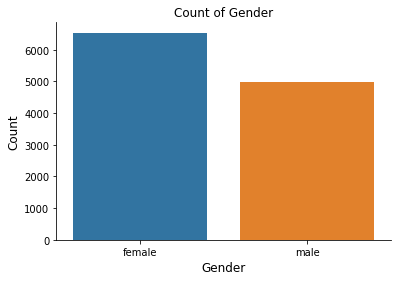

In [18]:
plt.title('Count of Gender', size=12)
sns.countplot(targets.gender)
plt.ylabel('Count', size=12)
plt.xlabel('Gender', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

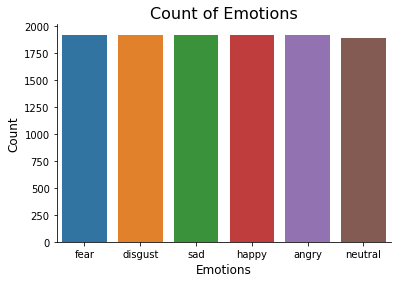

In [19]:
plt.title('Count of Emotions', size=16)
sns.countplot(targets.emotion)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [22]:
labels = {'disgust':0,'happy':1,'sad':2,'neutral':3,'fear':4,'angry':5}
targets.replace({'Emotions':labels},inplace=True)

In [21]:
num_mfcc=13
n_fft=2048
hop_length=512
SAMPLE_RATE = 22050
data = {
        "labels": [],
        "mfcc": []
    }
for i in range(11510):
    data['labels'].append(targets.iloc[i,0])
    signal, sample_rate = librosa.load(targets.iloc[i,2], sr=SAMPLE_RATE)
    mfcc = librosa.feature.mfcc(signal, sample_rate, n_mfcc=13, n_fft=2048, hop_length=512)
    mfcc = mfcc.T
    data["mfcc"].append(np.asarray(mfcc))

KeyboardInterrupt: 

In [ ]:
X = np.asarray(data['mfcc'])
y = np.asarray(data["labels"])

In [ ]:
X = tf.keras.preprocessing.sequence.pad_sequences(X)
X.shape

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2)

In [ ]:
def build_model(input_shape):
    model = tf.keras.Sequential()

    model.add(LSTM(128, input_shape=input_shape, return_sequences=True))
    model.add(LSTM(64))
    
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))

    model.add(Dense(6, activation='softmax'))

    return model

In [ ]:
# create network
input_shape = (None,13)
model = build_model(input_shape)

# compile model
optimiser = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

model.summary()

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=30)

In [ ]:
model

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print("Test Accuracy: ",test_acc)

In [ ]:
model.predict()

In [ ]:
confusion_matrix()

In [ ]:
targets['path'].nunique()

In [ ]:
targets[targets['emotion']=='disgust']

In [ ]:
1923

In [ ]:
crema_df.shape[0]+tess_df.shape[0]+ravdess_df.shape[0]+savee_df.shape[0]

In [ ]:
tess_df.shape[0]

In [ ]:
ravdess_df.shape[0]

In [ ]:
savee_df.shape[0]

In [ ]:
targets.shape

In [ ]:
targets = pd.concat([crema_df,tess_df,ravdess_df,savee_df])
targets['emotion'].unique()

In [ ]:
targets.shape

In [ ]:
targets = targets[targets['emotion']!='surprise']
targets = targets[targets['emotion']!='fear']
targets = targets[targets['emotion']!='disgust']
targets.shape